In [1]:
#Example from https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import h5py

import sys

torch.cuda.empty_cache()

In [2]:
class TBL_Dataset(Dataset):
    """Turbulent boundary layer dataset."""

    def __init__(self, filename, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        f = h5py.File(filename, "r")

        # Read attributes
        #print('Attributes:')
        #print(list(f.attrs))
        self.dstar = f.attrs['dstar']
        self.nplanes = int(f.attrs['nplanes'])
        self.nx = int(f.attrs['nx'])
        self.ny = int(f.attrs['ny'])
        self.nz = int(f.attrs['nz'])
        self.re = f.attrs['re']
        self.xl = f.attrs['xl']
        self.zl = f.attrs['zl']

        
        
        # Read data sets
        uzy = f['u']
        self.u = np.transpose(uzy, (1, 0, 2))
        #self.u = (self.u-np.mean(self.u,axis=2).reshape(self.u.shape[0],self.u.shape[0],1)).astype(float)
        vzy = f['v']
        self.v = np.transpose(vzy, (1, 0, 2))
        #self.v = (self.v-np.mean(self.v,axis=2).reshape(self.u.shape[0],self.u.shape[0],1)).astype(float)
        wzy = f['w']
        self.w = np.transpose(wzy, (1, 0, 2))
        #self.w = (self.w-np.mean(self.w,axis=2).reshape(self.u.shape[0],self.u.shape[0],1)).astype(float)
        self.y = np.copy(f['y'])
        self.z = np.copy(f['z'])
        #t = f['t']


        f.close()
        
        self.transform = transform

    def __len__(self):
        return self.u.shape[2]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        field = np.zeros((self.u.shape[0],self.u.shape[1],3))
        field[:,:,0] = self.u[:,:,idx].reshape(self.u.shape[0],self.u.shape[1],1)[:,:,0]
        #field[:,:,1] = self.v[:,:,idx].reshape(self.v.shape[0],self.u.shape[1],1)[:,:,0]
        #field[:,:,2] = self.w[:,:,idx].reshape(self.w.shape[0],self.u.shape[1],1)[:,:,0]
        
        sample = field

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        field = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        field = field.transpose((2, 0, 1))
        return torch.from_numpy(field)

In [3]:
data_dir = './../subsampled_TBL_data.hdf5'

train_dataset = TBL_Dataset(data_dir,ToTensor())
m=len(train_dataset)

In [4]:
print(train_dataset[0].shape)

torch.Size([3, 64, 64])


In [5]:
print(np.mean(train_dataset.u,axis=2).shape)

(64, 64)


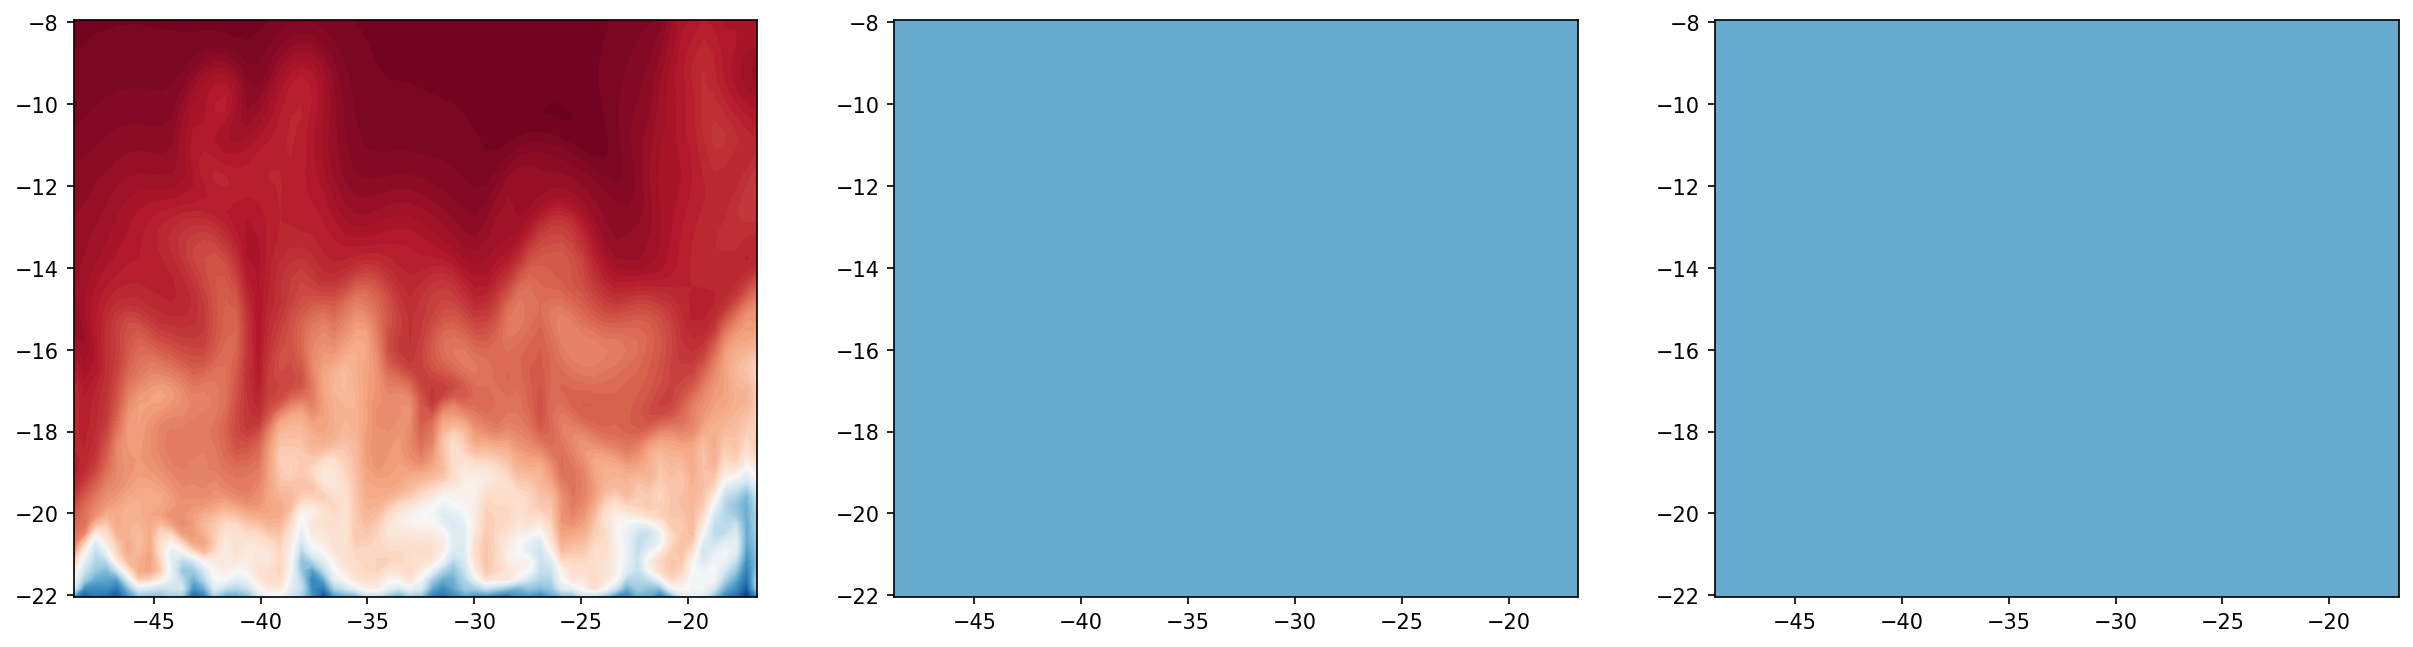

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


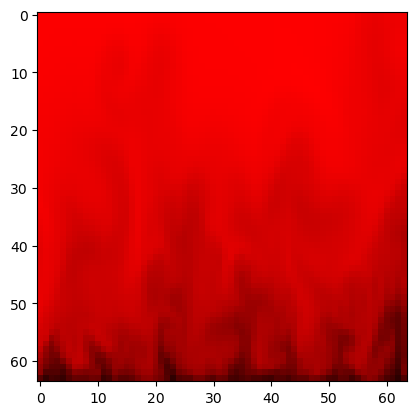

In [6]:
[yy,zz] = np.meshgrid(train_dataset.y,train_dataset.z)
def show_image(img):
    
    cmapp='RdBu_r'
    npimg = img.numpy()

    fig, ax = plt.subplots(1, 3,figsize=(20, 5), dpi=150)
    c1=ax[0].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,0].T,levels=100,cmap=cmapp)
    c2=ax[1].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,1].T,levels=100,cmap=cmapp)
    c3=ax[2].contourf(zz,yy,np.transpose(npimg, (1, 2, 0))[:,:,2].T,levels=100,cmap=cmapp)
    plt.show()
    
    
    
    #fig, ax = plt.subplots(1, 1,figsize=(20, 10), dpi=150)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

show_image(train_dataset[0])

In [7]:
train_data, val_data, test_data = random_split(train_dataset, [int(m*0.5), int(m*0.3), int(m*0.2)])
print(train_data[0].shape)

torch.Size([3, 64, 64])


In [8]:
batch_size=32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

i=0
for plane_batch in train_loader:
    i=i+1
    if i==2:
        break
print(plane_batch.size())

torch.Size([32, 3, 64, 64])


In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            #nn.ReLU(True),
            #nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(16*32*32, 2048),
            nn.ReLU(True),
            nn.Linear(2048, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.encoder_lin(x)
        #print("===")
        #print(x.shape)
        
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 16*32*32),
            nn.ReLU(True)
        )
        
        self.Lrelu = nn.LeakyReLU(0.1)

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(16, 32, 32))

        self.decoder_conv = nn.Sequential(
            #nn.ConvTranspose2d(32, 16, 3, 
            #stride=1,padding=1, output_padding=0),
            #nn.BatchNorm2d(16),
            #nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 3, 
            stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=1, 
            padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=1, 
            padding=1, output_padding=0)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        #print(x.shape)
        x = self.unflatten(x) 
        #print(x.shape)
        x = self.decoder_conv(x)
        #print("===")
        #print(x.shape)
        x = torch.sigmoid(x)
        #x = self.Lrelu(x)
        
        return x

In [10]:
#enc=Encoder(8,128)
#dec=Decoder(8,128)
#print(plane_batch.type('torch.FloatTensor').shape)
#print("===")
#x=enc(plane_batch.type('torch.FloatTensor'))
#print("===")
#x=dec(x)

In [11]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 1024

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=2048, out_features=16384, bias=True)
    (3): ReLU(inplace=True)
  )
  (Lrelu): LeakyReLU(negative_slope=0.1)
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 32, 32))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [12]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = (image_batch.type('torch.FloatTensor')).to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [13]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            image_batch = (image_batch.type('torch.FloatTensor')).to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [14]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [15]:
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   #plot_ae_outputs(encoder,decoder,n=10)

	 partial train loss (single batch): 0.246833
	 partial train loss (single batch): 0.235027
	 partial train loss (single batch): 0.221005
	 partial train loss (single batch): 0.208394
	 partial train loss (single batch): 0.198455
	 partial train loss (single batch): 0.189968
	 partial train loss (single batch): 0.182375
	 partial train loss (single batch): 0.175766
	 partial train loss (single batch): 0.169095
	 partial train loss (single batch): 0.162789
	 partial train loss (single batch): 0.156958
	 partial train loss (single batch): 0.151467
	 partial train loss (single batch): 0.145848
	 partial train loss (single batch): 0.140842
	 partial train loss (single batch): 0.135513
	 partial train loss (single batch): 0.130421
	 partial train loss (single batch): 0.125812
	 partial train loss (single batch): 0.121318
	 partial train loss (single batch): 0.116522
	 partial train loss (single batch): 0.112466
	 partial train loss (single batch): 0.107935
	 partial train loss (single batch

	 partial train loss (single batch): 0.004603
	 partial train loss (single batch): 0.004687
	 partial train loss (single batch): 0.004643
	 partial train loss (single batch): 0.004544
	 partial train loss (single batch): 0.004598
	 partial train loss (single batch): 0.004488
	 partial train loss (single batch): 0.004524
	 partial train loss (single batch): 0.004442
	 partial train loss (single batch): 0.004392
	 partial train loss (single batch): 0.004336
	 partial train loss (single batch): 0.004270
	 partial train loss (single batch): 0.004320
	 partial train loss (single batch): 0.004361
	 partial train loss (single batch): 0.004357
	 partial train loss (single batch): 0.004246
	 partial train loss (single batch): 0.004170
	 partial train loss (single batch): 0.004252
	 partial train loss (single batch): 0.004207
	 partial train loss (single batch): 0.004214
	 partial train loss (single batch): 0.004165
	 partial train loss (single batch): 0.004163
	 partial train loss (single batch

	 partial train loss (single batch): 0.002437
	 partial train loss (single batch): 0.002449
	 partial train loss (single batch): 0.002448
	 partial train loss (single batch): 0.002403
	 partial train loss (single batch): 0.002366
	 partial train loss (single batch): 0.002455
	 partial train loss (single batch): 0.002378
	 partial train loss (single batch): 0.002323
	 partial train loss (single batch): 0.002338
	 partial train loss (single batch): 0.002447
	 partial train loss (single batch): 0.002347
	 partial train loss (single batch): 0.002333
	 partial train loss (single batch): 0.002440
	 partial train loss (single batch): 0.002394
	 partial train loss (single batch): 0.002335
	 partial train loss (single batch): 0.002388
	 partial train loss (single batch): 0.002358
	 partial train loss (single batch): 0.002384
	 partial train loss (single batch): 0.002395
	 partial train loss (single batch): 0.002390
	 partial train loss (single batch): 0.002437
	 partial train loss (single batch

	 partial train loss (single batch): 0.002059
	 partial train loss (single batch): 0.002024
	 partial train loss (single batch): 0.002015
	 partial train loss (single batch): 0.002066
	 partial train loss (single batch): 0.001919
	 partial train loss (single batch): 0.002013
	 partial train loss (single batch): 0.001987
	 partial train loss (single batch): 0.001913
	 partial train loss (single batch): 0.001933
	 partial train loss (single batch): 0.001917
	 partial train loss (single batch): 0.001971
	 partial train loss (single batch): 0.002019
	 partial train loss (single batch): 0.002051
	 partial train loss (single batch): 0.001951
	 partial train loss (single batch): 0.001912
	 partial train loss (single batch): 0.001989
	 partial train loss (single batch): 0.002005
	 partial train loss (single batch): 0.002005
	 partial train loss (single batch): 0.002025
	 partial train loss (single batch): 0.002027
	 partial train loss (single batch): 0.001978
	 partial train loss (single batch

	 partial train loss (single batch): 0.001801
	 partial train loss (single batch): 0.001820
	 partial train loss (single batch): 0.001817
	 partial train loss (single batch): 0.001821
	 partial train loss (single batch): 0.001757
	 partial train loss (single batch): 0.001832
	 partial train loss (single batch): 0.001769
	 partial train loss (single batch): 0.001731
	 partial train loss (single batch): 0.001746
	 partial train loss (single batch): 0.001864
	 partial train loss (single batch): 0.001766
	 partial train loss (single batch): 0.001770
	 partial train loss (single batch): 0.001868
	 partial train loss (single batch): 0.001829
	 partial train loss (single batch): 0.001766
	 partial train loss (single batch): 0.001803
	 partial train loss (single batch): 0.001795
	 partial train loss (single batch): 0.001841
	 partial train loss (single batch): 0.001843
	 partial train loss (single batch): 0.001838
	 partial train loss (single batch): 0.001877
	 partial train loss (single batch

	 partial train loss (single batch): 0.001810
	 partial train loss (single batch): 0.001779
	 partial train loss (single batch): 0.001762
	 partial train loss (single batch): 0.001816
	 partial train loss (single batch): 0.001679
	 partial train loss (single batch): 0.001760
	 partial train loss (single batch): 0.001734
	 partial train loss (single batch): 0.001672
	 partial train loss (single batch): 0.001707
	 partial train loss (single batch): 0.001658
	 partial train loss (single batch): 0.001713
	 partial train loss (single batch): 0.001812
	 partial train loss (single batch): 0.001792
	 partial train loss (single batch): 0.001695
	 partial train loss (single batch): 0.001673
	 partial train loss (single batch): 0.001772
	 partial train loss (single batch): 0.001787
	 partial train loss (single batch): 0.001772
	 partial train loss (single batch): 0.001788
	 partial train loss (single batch): 0.001798
	 partial train loss (single batch): 0.001747
	 partial train loss (single batch

	 partial train loss (single batch): 0.001671
	 partial train loss (single batch): 0.001685
	 partial train loss (single batch): 0.001695
	 partial train loss (single batch): 0.001710
	 partial train loss (single batch): 0.001620
	 partial train loss (single batch): 0.001682
	 partial train loss (single batch): 0.001648
	 partial train loss (single batch): 0.001621
	 partial train loss (single batch): 0.001636
	 partial train loss (single batch): 0.001753
	 partial train loss (single batch): 0.001645
	 partial train loss (single batch): 0.001658
	 partial train loss (single batch): 0.001763
	 partial train loss (single batch): 0.001729
	 partial train loss (single batch): 0.001652
	 partial train loss (single batch): 0.001673
	 partial train loss (single batch): 0.001684
	 partial train loss (single batch): 0.001721
	 partial train loss (single batch): 0.001720
	 partial train loss (single batch): 0.001726
	 partial train loss (single batch): 0.001765
	 partial train loss (single batch

	 partial train loss (single batch): 0.001729
	 partial train loss (single batch): 0.001712
	 partial train loss (single batch): 0.001685
	 partial train loss (single batch): 0.001747
	 partial train loss (single batch): 0.001609
	 partial train loss (single batch): 0.001696
	 partial train loss (single batch): 0.001666
	 partial train loss (single batch): 0.001592
	 partial train loss (single batch): 0.001634
	 partial train loss (single batch): 0.001587
	 partial train loss (single batch): 0.001628
	 partial train loss (single batch): 0.001726
	 partial train loss (single batch): 0.001727
	 partial train loss (single batch): 0.001620
	 partial train loss (single batch): 0.001601
	 partial train loss (single batch): 0.001696
	 partial train loss (single batch): 0.001697
	 partial train loss (single batch): 0.001695
	 partial train loss (single batch): 0.001712
	 partial train loss (single batch): 0.001727
	 partial train loss (single batch): 0.001674
	 partial train loss (single batch

	 partial train loss (single batch): 0.001625
	 partial train loss (single batch): 0.001634
	 partial train loss (single batch): 0.001640
	 partial train loss (single batch): 0.001663
	 partial train loss (single batch): 0.001569
	 partial train loss (single batch): 0.001636
	 partial train loss (single batch): 0.001606
	 partial train loss (single batch): 0.001570
	 partial train loss (single batch): 0.001589
	 partial train loss (single batch): 0.001699
	 partial train loss (single batch): 0.001599
	 partial train loss (single batch): 0.001603
	 partial train loss (single batch): 0.001715
	 partial train loss (single batch): 0.001665
	 partial train loss (single batch): 0.001596
	 partial train loss (single batch): 0.001635
	 partial train loss (single batch): 0.001633
	 partial train loss (single batch): 0.001672
	 partial train loss (single batch): 0.001671
	 partial train loss (single batch): 0.001673
	 partial train loss (single batch): 0.001717
	 partial train loss (single batch

	 partial train loss (single batch): 0.001690
	 partial train loss (single batch): 0.001678
	 partial train loss (single batch): 0.001653
	 partial train loss (single batch): 0.001712
	 partial train loss (single batch): 0.001580
	 partial train loss (single batch): 0.001663
	 partial train loss (single batch): 0.001633
	 partial train loss (single batch): 0.001559
	 partial train loss (single batch): 0.001605
	 partial train loss (single batch): 0.001557
	 partial train loss (single batch): 0.001595
	 partial train loss (single batch): 0.001689
	 partial train loss (single batch): 0.001697
	 partial train loss (single batch): 0.001603
	 partial train loss (single batch): 0.001562
	 partial train loss (single batch): 0.001651
	 partial train loss (single batch): 0.001662
	 partial train loss (single batch): 0.001663
	 partial train loss (single batch): 0.001671
	 partial train loss (single batch): 0.001696
	 partial train loss (single batch): 0.001641
	 partial train loss (single batch

	 partial train loss (single batch): 0.001591
	 partial train loss (single batch): 0.001612
	 partial train loss (single batch): 0.001609
	 partial train loss (single batch): 0.001635
	 partial train loss (single batch): 0.001545
	 partial train loss (single batch): 0.001609
	 partial train loss (single batch): 0.001577
	 partial train loss (single batch): 0.001550
	 partial train loss (single batch): 0.001566
	 partial train loss (single batch): 0.001679
	 partial train loss (single batch): 0.001576
	 partial train loss (single batch): 0.001572
	 partial train loss (single batch): 0.001683
	 partial train loss (single batch): 0.001634
	 partial train loss (single batch): 0.001569
	 partial train loss (single batch): 0.001627
	 partial train loss (single batch): 0.001594
	 partial train loss (single batch): 0.001643
	 partial train loss (single batch): 0.001655
	 partial train loss (single batch): 0.001657
	 partial train loss (single batch): 0.001690
	 partial train loss (single batch

	 partial train loss (single batch): 0.001665
	 partial train loss (single batch): 0.001643
	 partial train loss (single batch): 0.001627
	 partial train loss (single batch): 0.001672
	 partial train loss (single batch): 0.001556
	 partial train loss (single batch): 0.001643
	 partial train loss (single batch): 0.001552
	 partial train loss (single batch): 0.001594
	 partial train loss (single batch): 0.001588
	 partial train loss (single batch): 0.001585
	 partial train loss (single batch): 0.001542
	 partial train loss (single batch): 0.001666
	 partial train loss (single batch): 0.001646
	 partial train loss (single batch): 0.001572
	 partial train loss (single batch): 0.001519
	 partial train loss (single batch): 0.001612
	 partial train loss (single batch): 0.001645
	 partial train loss (single batch): 0.001641
	 partial train loss (single batch): 0.001604
	 partial train loss (single batch): 0.001629
	 partial train loss (single batch): 0.001593
	 partial train loss (single batch

	 partial train loss (single batch): 0.001498
	 partial train loss (single batch): 0.001530
	 partial train loss (single batch): 0.001512
	 partial train loss (single batch): 0.001578
	 partial train loss (single batch): 0.001479
	 partial train loss (single batch): 0.001522
	 partial train loss (single batch): 0.001468
	 partial train loss (single batch): 0.001530
	 partial train loss (single batch): 0.001503
	 partial train loss (single batch): 0.001555
	 partial train loss (single batch): 0.001527
	 partial train loss (single batch): 0.001491
	 partial train loss (single batch): 0.001630
	 partial train loss (single batch): 0.001517
	 partial train loss (single batch): 0.001487
	 partial train loss (single batch): 0.001535
	 partial train loss (single batch): 0.001530
	 partial train loss (single batch): 0.001578
	 partial train loss (single batch): 0.001543
	 partial train loss (single batch): 0.001573
	 partial train loss (single batch): 0.001597
	 partial train loss (single batch

	 partial train loss (single batch): 0.001538
	 partial train loss (single batch): 0.001515
	 partial train loss (single batch): 0.001483
	 partial train loss (single batch): 0.001539
	 partial train loss (single batch): 0.001453
	 partial train loss (single batch): 0.001501
	 partial train loss (single batch): 0.001419
	 partial train loss (single batch): 0.001447
	 partial train loss (single batch): 0.001418
	 partial train loss (single batch): 0.001425
	 partial train loss (single batch): 0.001438
	 partial train loss (single batch): 0.001514
	 partial train loss (single batch): 0.001515
	 partial train loss (single batch): 0.001449
	 partial train loss (single batch): 0.001392
	 partial train loss (single batch): 0.001502
	 partial train loss (single batch): 0.001478
	 partial train loss (single batch): 0.001562
	 partial train loss (single batch): 0.001502
	 partial train loss (single batch): 0.001502
	 partial train loss (single batch): 0.001497
	 partial train loss (single batch

	 partial train loss (single batch): 0.001459
	 partial train loss (single batch): 0.001460
	 partial train loss (single batch): 0.001455
	 partial train loss (single batch): 0.001472
	 partial train loss (single batch): 0.001406
	 partial train loss (single batch): 0.001456
	 partial train loss (single batch): 0.001405
	 partial train loss (single batch): 0.001438
	 partial train loss (single batch): 0.001470
	 partial train loss (single batch): 0.001469
	 partial train loss (single batch): 0.001476
	 partial train loss (single batch): 0.001407
	 partial train loss (single batch): 0.001544
	 partial train loss (single batch): 0.001457
	 partial train loss (single batch): 0.001460
	 partial train loss (single batch): 0.001460
	 partial train loss (single batch): 0.001433
	 partial train loss (single batch): 0.001502
	 partial train loss (single batch): 0.001499
	 partial train loss (single batch): 0.001485
	 partial train loss (single batch): 0.001506
	 partial train loss (single batch

	 partial train loss (single batch): 0.001514
	 partial train loss (single batch): 0.001496
	 partial train loss (single batch): 0.001461
	 partial train loss (single batch): 0.001527
	 partial train loss (single batch): 0.001450
	 partial train loss (single batch): 0.001490
	 partial train loss (single batch): 0.001411
	 partial train loss (single batch): 0.001423
	 partial train loss (single batch): 0.001408
	 partial train loss (single batch): 0.001389
	 partial train loss (single batch): 0.001428
	 partial train loss (single batch): 0.001502
	 partial train loss (single batch): 0.001512
	 partial train loss (single batch): 0.001431
	 partial train loss (single batch): 0.001383
	 partial train loss (single batch): 0.001484
	 partial train loss (single batch): 0.001455
	 partial train loss (single batch): 0.001529
	 partial train loss (single batch): 0.001471
	 partial train loss (single batch): 0.001488
	 partial train loss (single batch): 0.001471
	 partial train loss (single batch

	 partial train loss (single batch): 0.001447
	 partial train loss (single batch): 0.001447
	 partial train loss (single batch): 0.001452
	 partial train loss (single batch): 0.001456
	 partial train loss (single batch): 0.001398
	 partial train loss (single batch): 0.001441
	 partial train loss (single batch): 0.001390
	 partial train loss (single batch): 0.001426
	 partial train loss (single batch): 0.001461
	 partial train loss (single batch): 0.001458
	 partial train loss (single batch): 0.001475
	 partial train loss (single batch): 0.001403
	 partial train loss (single batch): 0.001539
	 partial train loss (single batch): 0.001457
	 partial train loss (single batch): 0.001456
	 partial train loss (single batch): 0.001454
	 partial train loss (single batch): 0.001427
	 partial train loss (single batch): 0.001497
	 partial train loss (single batch): 0.001489
	 partial train loss (single batch): 0.001473
	 partial train loss (single batch): 0.001497
	 partial train loss (single batch

	 partial train loss (single batch): 0.001501
	 partial train loss (single batch): 0.001490
	 partial train loss (single batch): 0.001455
	 partial train loss (single batch): 0.001520
	 partial train loss (single batch): 0.001448
	 partial train loss (single batch): 0.001481
	 partial train loss (single batch): 0.001404
	 partial train loss (single batch): 0.001413
	 partial train loss (single batch): 0.001401
	 partial train loss (single batch): 0.001377
	 partial train loss (single batch): 0.001424
	 partial train loss (single batch): 0.001494
	 partial train loss (single batch): 0.001504
	 partial train loss (single batch): 0.001431
	 partial train loss (single batch): 0.001387
	 partial train loss (single batch): 0.001473
	 partial train loss (single batch): 0.001447
	 partial train loss (single batch): 0.001524
	 partial train loss (single batch): 0.001469
	 partial train loss (single batch): 0.001481
	 partial train loss (single batch): 0.001464
	 partial train loss (single batch

	 partial train loss (single batch): 0.001444
	 partial train loss (single batch): 0.001437
	 partial train loss (single batch): 0.001446
	 partial train loss (single batch): 0.001450
	 partial train loss (single batch): 0.001390
	 partial train loss (single batch): 0.001434
	 partial train loss (single batch): 0.001379
	 partial train loss (single batch): 0.001413
	 partial train loss (single batch): 0.001454
	 partial train loss (single batch): 0.001452
	 partial train loss (single batch): 0.001460
	 partial train loss (single batch): 0.001390
	 partial train loss (single batch): 0.001533
	 partial train loss (single batch): 0.001448
	 partial train loss (single batch): 0.001452
	 partial train loss (single batch): 0.001447
	 partial train loss (single batch): 0.001422
	 partial train loss (single batch): 0.001488
	 partial train loss (single batch): 0.001482
	 partial train loss (single batch): 0.001468
	 partial train loss (single batch): 0.001490
	 partial train loss (single batch

	 partial train loss (single batch): 0.001499
	 partial train loss (single batch): 0.001486
	 partial train loss (single batch): 0.001451
	 partial train loss (single batch): 0.001524
	 partial train loss (single batch): 0.001442
	 partial train loss (single batch): 0.001476
	 partial train loss (single batch): 0.001407
	 partial train loss (single batch): 0.001408
	 partial train loss (single batch): 0.001395
	 partial train loss (single batch): 0.001374
	 partial train loss (single batch): 0.001422
	 partial train loss (single batch): 0.001492
	 partial train loss (single batch): 0.001509
	 partial train loss (single batch): 0.001421
	 partial train loss (single batch): 0.001379
	 partial train loss (single batch): 0.001476
	 partial train loss (single batch): 0.001440
	 partial train loss (single batch): 0.001523
	 partial train loss (single batch): 0.001467
	 partial train loss (single batch): 0.001475
	 partial train loss (single batch): 0.001461
	 partial train loss (single batch

In [16]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.0015389022883027792

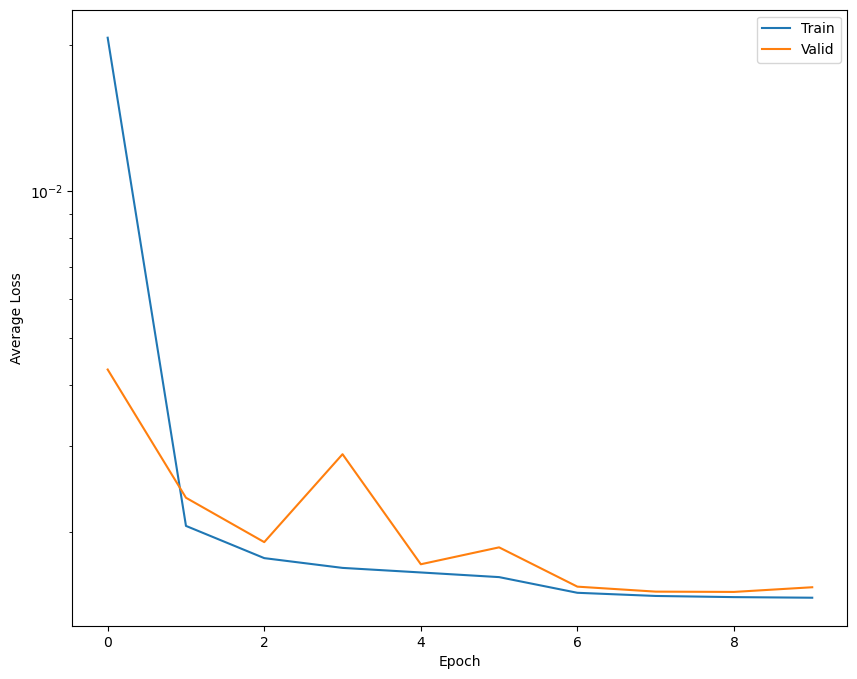

In [17]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# evaluate

In [18]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images = next(iter(test_loader))
    images = (images.type('torch.FloatTensor')).to(device)
    latent = encoder(images)
    latent = latent.cpu()


## Generate new samples from the random latent code
To generate new images from the latent code, we sample randomly from a normal distribution with the mean and standard deviation of the encoded data. These samples will be passed to the decoder, which will create the reconstructed images.



In [19]:
#def show_image(img):
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images = next(iter(test_loader))
    images_cpu=images.cpu()
    images = (images.type('torch.FloatTensor')).to(device)
    latent = encoder(images)
    latent_mode= latent.cpu()
    latent_cpu = latent.cpu()
   
     
    print(latent_mode.shape)
    print(latent_cpu.shape)

    mode=[0]
    
    for i in range(0,batch_size):
        for j in range(0,d):
            if j not in mode:
                latent_mode[i][j]=0
                
    latent_mode = latent_mode.to(device)
    
    img_recon = decoder(latent)
    img_recon_cpu = img_recon.cpu()
    
    mode_recon = decoder(latent_mode)
    mode_recon_cpu = mode_recon.cpu()
    
    
    print(img_recon_cpu[0].shape)

torch.Size([32, 1024])
torch.Size([32, 1024])
torch.Size([3, 64, 64])


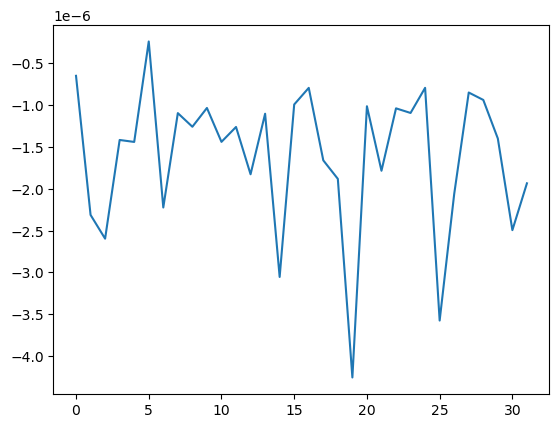

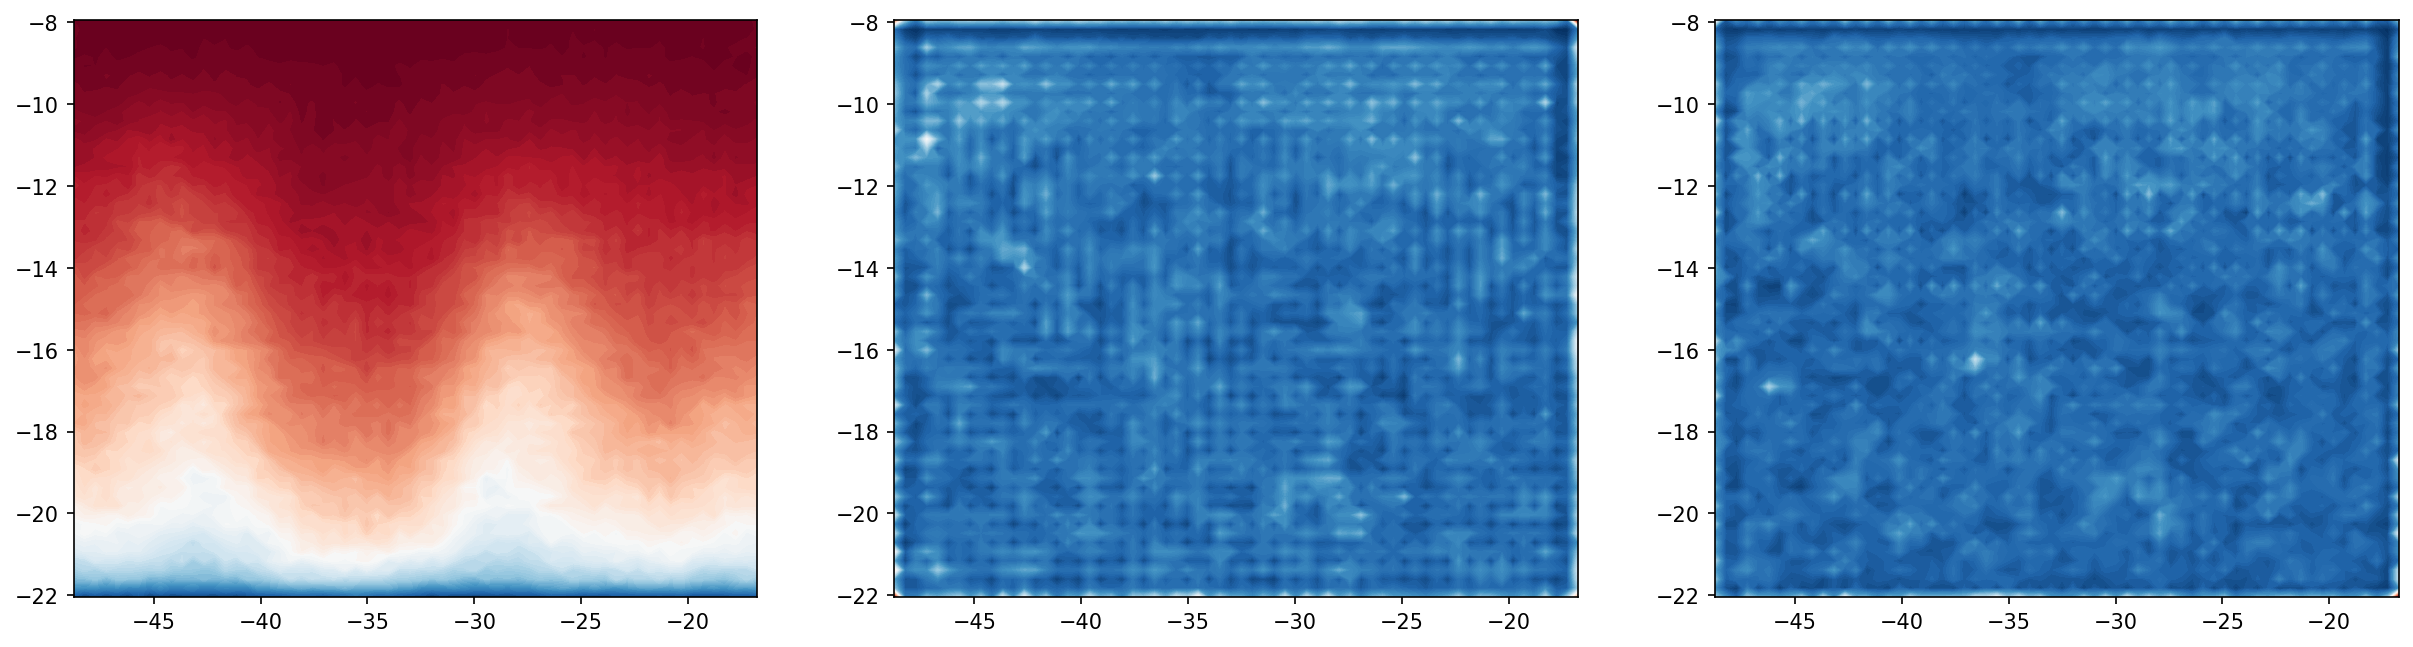

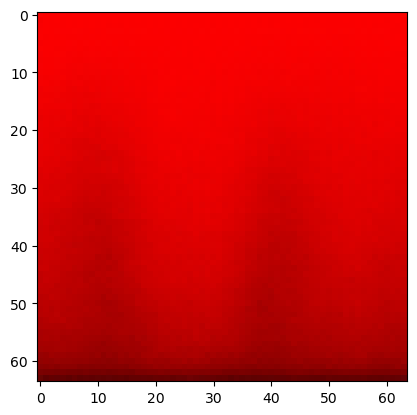

In [20]:
plt.plot(latent_cpu.numpy()[:,0])
plt.show()

show_image(mode_recon_cpu[0])

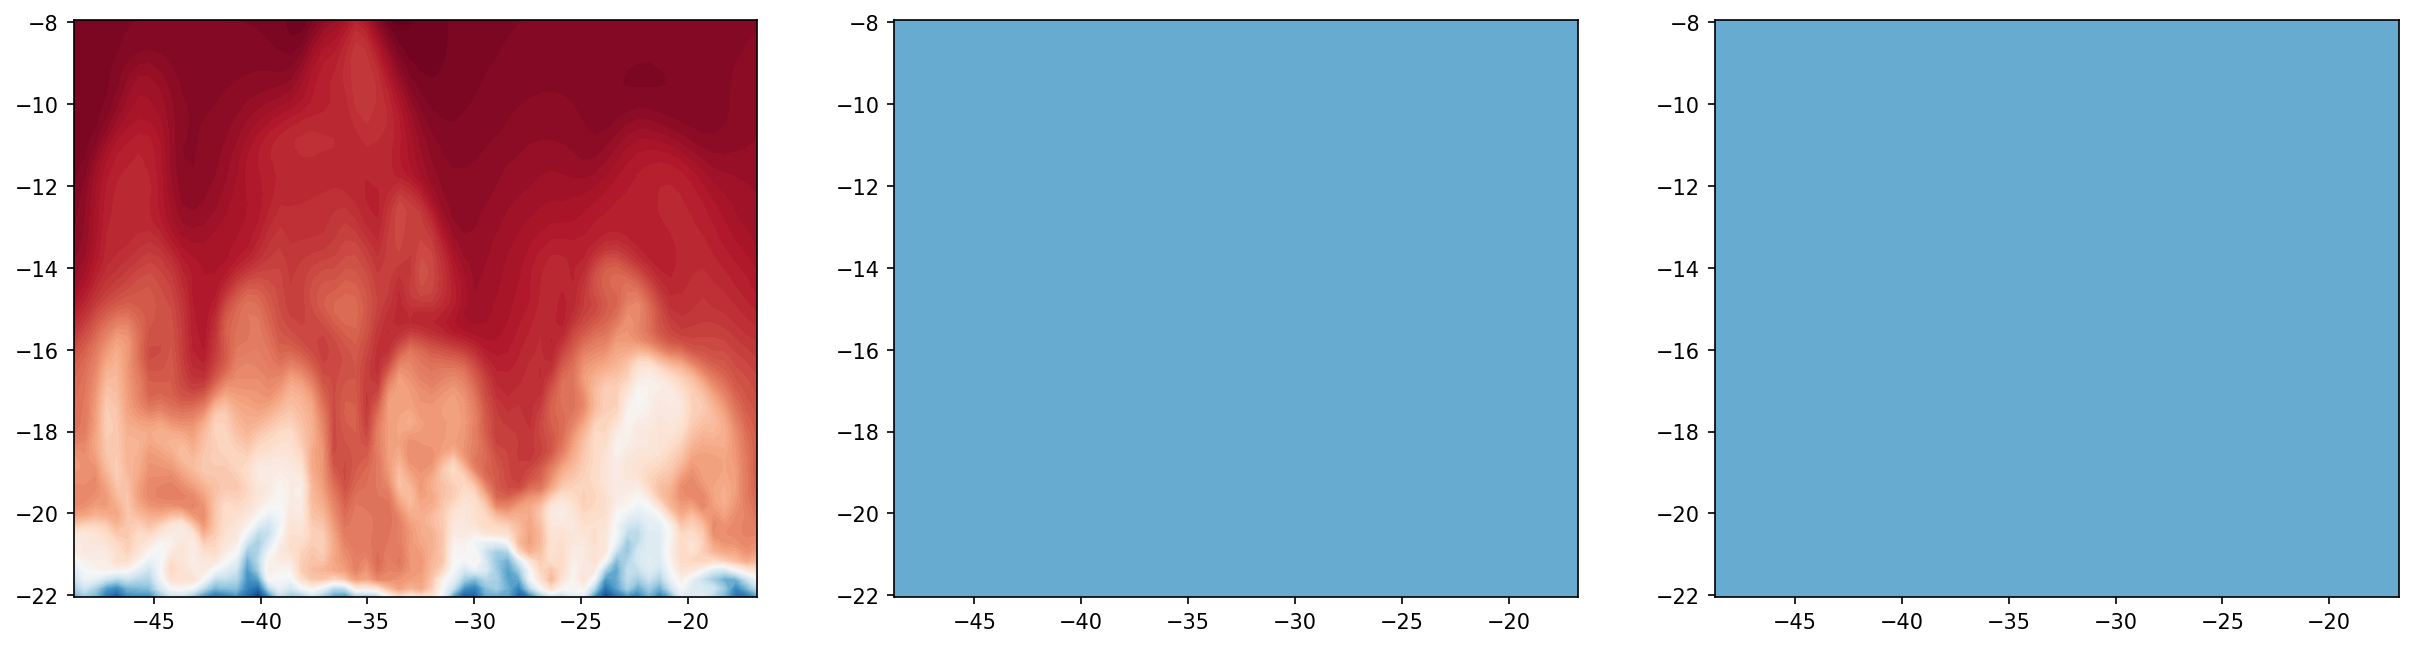

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


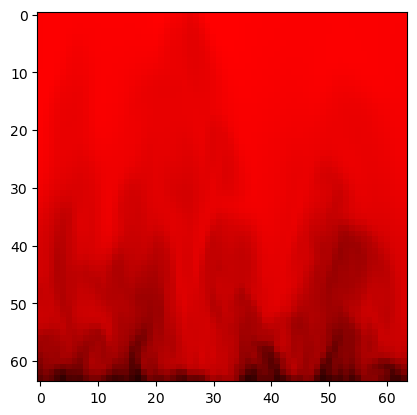

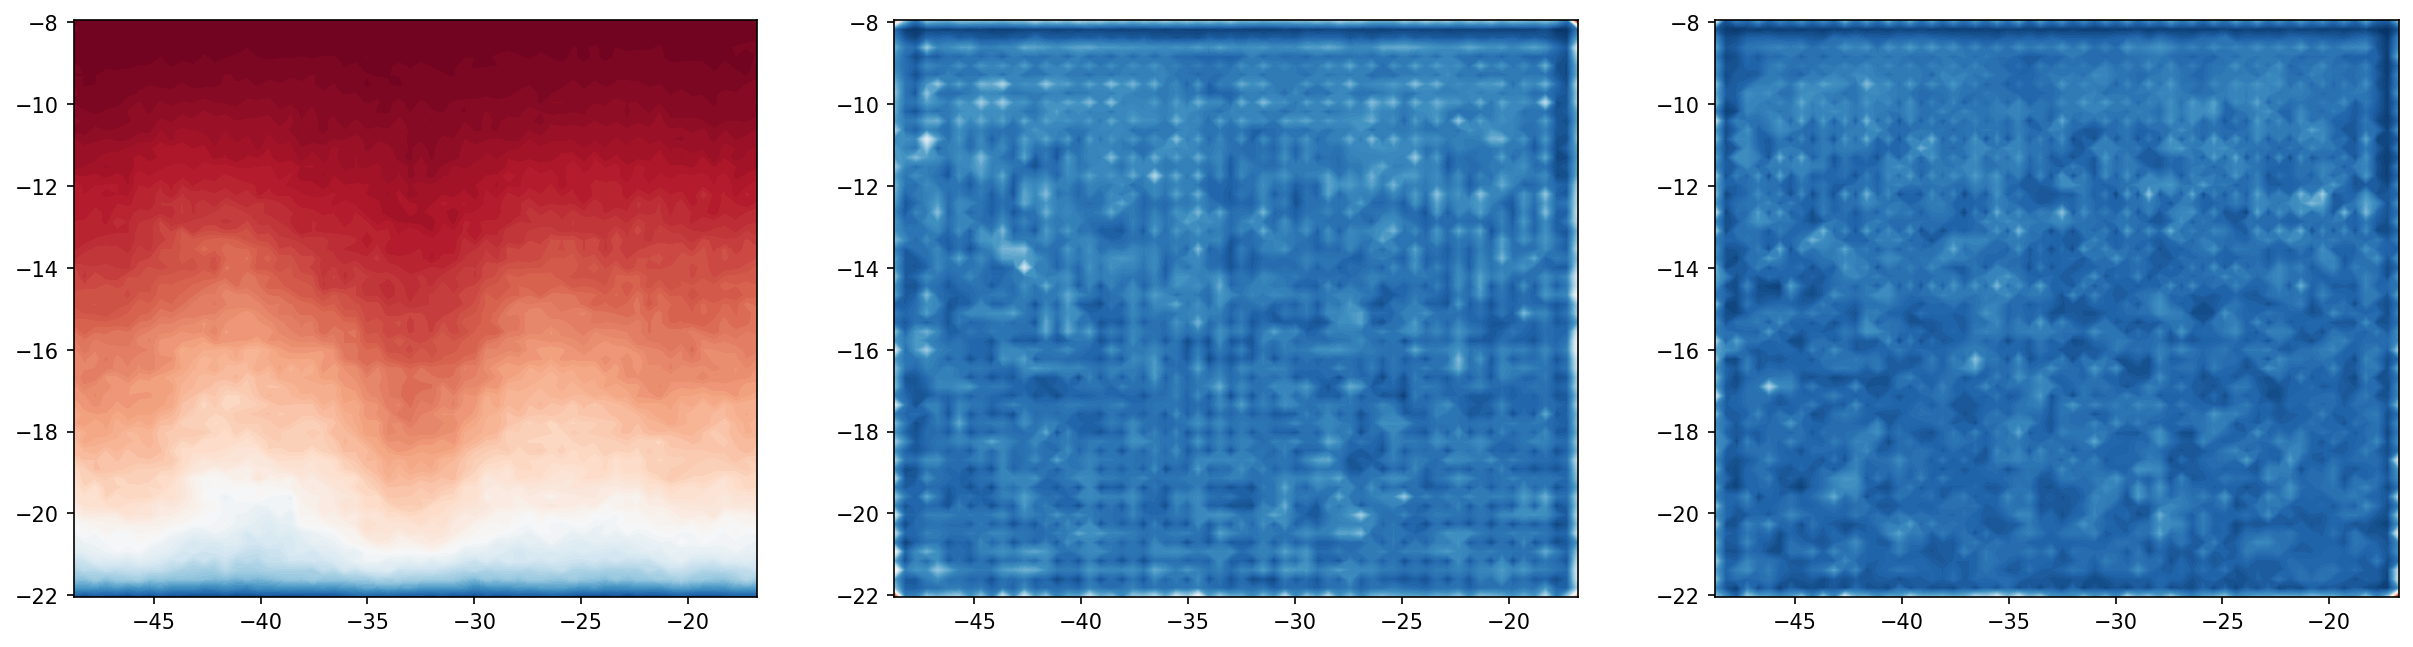

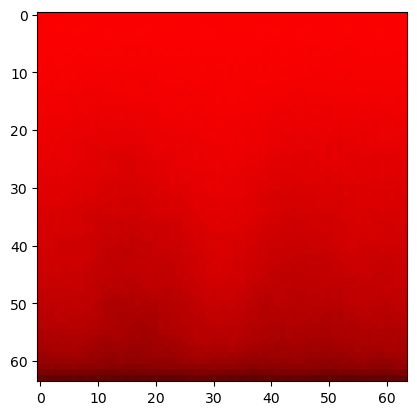

In [21]:
show_image(images_cpu[0])
show_image(img_recon_cpu[0])

In [22]:
sys.exit(0)

SystemExit: 0

C:\Users\adalb\anaconda3\envs\machine_learning\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Visualize the latent space with t-SNE
After we can observe dynamic visualization to see the latent space learned by the autoencoder. First, we create the encoded samples using the test set.

In [ ]:

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*8*8, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.encoder_lin(x)
        #print(x.shape)
        
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32*8*8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 8, 8))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        #print(x.shape)
        x = self.unflatten(x) 
        #print(x.shape)
        x = self.decoder_conv(x)
        #print(x.shape)
        x = torch.sigmoid(x)
        return x